In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf

from src.preprocess import preprocess_folder
from src.format_data import create_dataset
from src.model import create_embedding_model
from src.losses import get_companion_std

from tensorflow.keras.optimizers import Adam
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cube, psf, rot_angles, table = preprocess_folder(root='./data/fake', 
												 target_folder='./data/fake/preprocessed')

table = table[table['snr'] > 2]
window_size = 30
dataset = create_dataset(cube, psf, rot_angles, table, window_size=window_size,
                         batch_size=2000, repeat=5)

model = create_embedding_model(window_size=window_size)

optimizer = Adam(1e-3)
model.compile(loss_fn=get_companion_std, optimizer=optimizer)

es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=1e-3,
        patience=20,
        mode='min',
        restore_best_weights=True,
    )

[INFO] Restoring saved values
(30, 30, 1)


In [5]:
model.summary()

Model: "ConvNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 psf (InputLayer)               [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 psfCNN (PSFConvBlock)          (None, 1152)         19104       ['psf[0][0]']                    
                                                                                                  
 flux (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 fluxREG (FluxRegressor)        (None,)              76161       ['psfCNN[0][0]']                 
                                                                                            

In [6]:
%%time
hist = model.fit(dataset, epochs=1000, callbacks=[es])

Epoch 1/1000
(30, 30, 1)
(30, 30, 1)


2023-06-06 15:57:42.956735: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-06-06 15:57:44.450275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 6s 6s/step - loss: 15892.9678
Epoch 2/1000
1/1 [==============================] - 0s 336ms/step - loss: 15892.6904
Epoch 3/1000
1/1 [==============================] - 0s 352ms/step - loss: 15892.2969
Epoch 4/1000
1/1 [==============================] - 0s 322ms/step - loss: 15891.6641
Epoch 5/1000
1/1 [==============================] - 0s 329ms/step - loss: 15890.7090
Epoch 6/1000
1/1 [==============================] - 0s 295ms/step - loss: 15889.3662
Epoch 7/1000
1/1 [==============================] - 0s 366ms/step - loss: 15887.6162
Epoch 8/1000
1/1 [==============================] - 0s 298ms/step - loss: 15885.4062
Epoch 9/1000
1/1 [==============================] - 0s 356ms/step - loss: 15882.7344
Epoch 10/1000
1/1 [==============================] - 0s 351ms/step - loss: 15879.6377
Epoch 11/1000
1/1 [==============================] - 0s 365ms/step - loss: 15876.1875
Epoch 12/1000
1/1 [==============================] - 0s 335ms/step - loss: 1587

1/1 [==============================] - 0s 349ms/step - loss: 15453.7451
Epoch 97/1000
1/1 [==============================] - 0s 362ms/step - loss: 15451.8857
Epoch 98/1000
1/1 [==============================] - 0s 359ms/step - loss: 15450.2695
Epoch 99/1000
1/1 [==============================] - 0s 290ms/step - loss: 15448.8906
Epoch 100/1000
1/1 [==============================] - 0s 325ms/step - loss: 15447.7354
Epoch 101/1000
1/1 [==============================] - 0s 319ms/step - loss: 15446.7939
Epoch 102/1000
1/1 [==============================] - 0s 331ms/step - loss: 15446.0518
Epoch 103/1000
1/1 [==============================] - 0s 317ms/step - loss: 15445.4902
Epoch 104/1000
1/1 [==============================] - 0s 371ms/step - loss: 15445.0908
Epoch 105/1000
1/1 [==============================] - 0s 352ms/step - loss: 15444.8330
Epoch 106/1000
1/1 [==============================] - 0s 308ms/step - loss: 15444.6953
Epoch 107/1000
1/1 [==============================] - 0s 367m

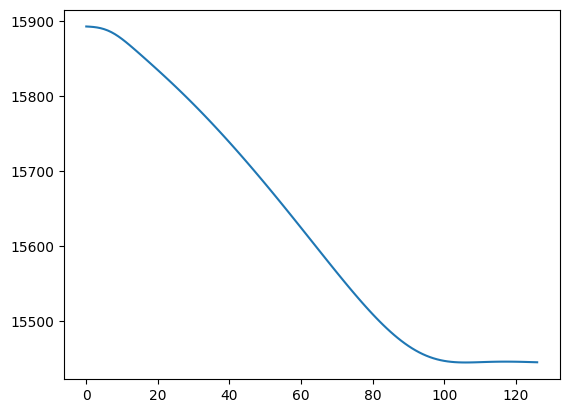

In [7]:
plt.plot(hist.history['loss'])

In [8]:
test_ds = create_dataset(cube, psf, rot_angles, table, window_size=window_size, batch_size=2000, repeat=1)

In [9]:
pred = model.predict(test_ds)

(30, 30, 1)
2/2 [==============================] - 5s 20ms/step
